In [1]:
# %env PYTORCH_ENABLE_MPS_FALLBACK=1
%load_ext autoreload
%autoreload

from bins import Bins
from eventsreader import Frame
from utils import calc_one_chi2, HistMaker1d, diff_hist, set_opt_text, set_th1, set_pad, geom_avg1d, ratio_err, symmetrize
from ROOT import TFile, TH1, TH3F, TF2, TF1, TCanvas, TStyle, gStyle, Form, Fit, TLegend
import scipy.optimize as opt
import math
import calendar, os
from time import time, gmtime

Welcome to JupyROOT 6.28/04


In [2]:
gStyle.SetOptStat(0)

same_sign_symm = False
ag1580ag = True
event_mixing = False
symmetrize_explicit = False
read_saved = True
range_used = range(0,12)

if read_saved:
    if event_mixing:
        if ag1580ag:
            DIR_NAME = "results_mixing_nu15_noise1em1_1d_ag1580ag"
        else:
            DIR_NAME = "results_mixing_nu15_noise1em1_1d"
    else:
        if ag1580ag:
           # DIR_NAME = "results_sameevt_nu15_noise1em1_1d_ag1580ag_noconstr"
            DIR_NAME = "results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr"
        else:
            DIR_NAME = "results_sameevt_nu15_noise1em1_1d"
else:
    current_GMT =   gmtime()
    time_stamp = calendar.timegm(current_GMT)
    DIR_NAME = f'results_{time_stamp}'
    os.mkdir(DIR_NAME)

In [3]:
ag1580ag = True

if ag1580ag:
    ekin = 1580
    filename_data_np = "063_088_ag158ag_3200A_accepted_np.dat"
   # filename_data_np = "mar19_diele_inmedium_helip1cm_ag1580ag_np.dat"
   # filename_data_np = "mar19_diele_inmedium_helip1cm_ag1580ag_jver22_np.dat"
    filename_data_pp = "063_088_ag158ag_3200A_accepted_pp.dat"
    filename_data_nn = "063_088_ag158ag_3200A_accepted_nn.dat"
    filename_data_np_mix = "063_088_ag158ag_3200A_accepted_np_mix_hc.dat"
    filename_data_pp_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_pp_mix_hc.dat"
    filename_data_nn_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_nn_mix_hc.dat"
    filename_MC_rho_4pi_heli0 = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_2_np_kine.dat"
    filename_MC_rho_4pi_heli1 = "mar19_diele_inmedium_helip1cm_ag1580ag_jver22_2_np_kine.dat"
    filename_MC_rho_heli0 = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_np.dat"
    filename_MC_rho_heli1 = "mar19_diele_inmedium_helip1cm_ag1580ag_jver22_np.dat"
    filename_MC_pi0 = "mar19_diele_pi0_heli0cm_ag1580ag_np.dat"
    filename_MC_mix = "mar19_diele_pi0_heli0cm_ag1580ag_np_mix.dat"
    if same_sign_symm:
        filename_data_pp = "063_088_ag158ag_3200A_accepted_pp_symm.dat"
        filename_data_nn = "063_088_ag158ag_3200A_accepted_nn_symm.dat"
        filename_data_pp_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_pp_mix_hc_symm.dat"
        filename_data_nn_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_nn_mix_hc_symm.dat"
else:
    ekin = 1230
    filename_data_np = "apr12_diele_088_090_ag123ag_2500A_accepted_np_2.dat"
    filename_data_pp = "088_090_ag123ag_2500A_accepted_pp.dat"
    filename_data_nn = "088_090_ag123ag_2500A_accepted_nn.dat"
    filename_data_np_mix = "088_090_ag123ag_2500A_accepted_np_mix_hc.dat"
    filename_data_pp_mix = "088_090_ag123ag_2500A_accepted_pp_mix_hc.dat"
    filename_data_nn_mix = "088_090_ag123ag_2500A_accepted_nn_mix_hc.dat"
    filename_MC_rho_heli0 = "mar19_diele_inmedium_heli0cm_np.dat"
    filename_MC_rho_heli1 = "mar19_diele_inmedium_helip1cm_np.dat"
    filename_MC_pi0 = "mar19_diele_pi0_heli0cm_ag1580ag_np.dat.dat"
    filename_MC_mix = "mar19_diele_pi0_heli0cm_np_mix.dat"


frame = Frame.HX

bins = Bins.readFrom("ranges.yml")
#histMakerData_np = HistMaker1d("apr12_diele_088_090_ag123ag_2500A_accepted_np_mix_hc_sample_2.dat", "_data", bins, frame)
if event_mixing:
    histMakerData_np = HistMaker1d(filename_data_np_mix, "_data_np", bins, frame, ekin)
else:
    histMakerData_np = HistMaker1d(filename_data_np, "_data_np", bins, frame, ekin)
histsData_np = histMakerData_np.make_hists()
histMakerData_pp = HistMaker1d(filename_data_pp, "_data_pp", bins, frame, ekin)
histsData_pp = histMakerData_pp.make_hists()
histMakerData_nn = HistMaker1d(filename_data_nn, "_data_nn", bins, frame, ekin)
histsData_nn = histMakerData_nn.make_hists()

histMakerData_np_mix = HistMaker1d(filename_data_np_mix, "_data_pp_mix", bins, frame, ekin)
histsData_np_mix = histMakerData_np_mix.make_hists()
histMakerData_pp_mix = HistMaker1d(filename_data_np_mix, "_data_pp_mix", bins, frame, ekin)
histsData_pp_mix = histMakerData_pp_mix.make_hists()
histMakerData_nn_mix = HistMaker1d(filename_data_nn_mix, "_data_nn_mix", bins, frame, ekin)
histsData_nn_mix = histMakerData_nn_mix.make_hists()

histMakerMC_rho_4pi_heli0 = HistMaker1d(filename_MC_rho_4pi_heli0, "_MC_rho_4pi_heli0", bins, frame, ekin)
histMakerMC_rho_4pi_heli1 = HistMaker1d(filename_MC_rho_4pi_heli1, "_MC_rho_4pi_heli1", bins, frame, ekin)
histMakerMC_rho_heli0 = HistMaker1d(filename_MC_rho_heli0, "_MC_rho_heli0", bins, frame, ekin)
histMakerMC_rho_heli1 = HistMaker1d(filename_MC_rho_heli1, "_MC_rho_heli1", bins, frame, ekin)
histMakerMC_rho = histMakerMC_rho_heli0
histMakerMC_pi0 = HistMaker1d(filename_MC_pi0, "_MC_pi0", bins, frame, ekin)
histMakerMC_mix = HistMaker1d(filename_MC_mix, "_MC_mix", bins, frame, ekin)
#histMakerMC_mix = HistMaker1d("test_inmedium_heli0cm_np_mix.dat", "_MC_rho_mix", bins, frame)
#histMakerMC_mix = HistMaker1d("mar19_diele_pi0_heli0cm_np_mix.dat", "_MC_rho_mix", bins, frame)
def get_hist_maker_mc(hist_index):
    if event_mixing:
        return histMakerMC_mix
    else:
        return histMakerMC_pi0 if hist_index < 3 else histMakerMC_rho

iter 0
#1 [[<cppyy.gbl.TH1F object at 0x15a56af10>, <cppyy.gbl.TH1F object at 0x15a56b7c0>, <cppyy.gbl.TH1F object at 0x15a56bbb0>, <cppyy.gbl.TH1F object at 0x15a56bfa0>, <cppyy.gbl.TH1F object at 0x15a56c390>, <cppyy.gbl.TH1F object at 0x15a56c780>, <cppyy.gbl.TH1F object at 0x15a56cb70>, <cppyy.gbl.TH1F object at 0x15a56cf60>, <cppyy.gbl.TH1F object at 0x15a56d350>, <cppyy.gbl.TH1F object at 0x15a56d740>, <cppyy.gbl.TH1F object at 0x15a56db30>, <cppyy.gbl.TH1F object at 0x15a56df20>], [<cppyy.gbl.TH1F object at 0x15a56e310>, <cppyy.gbl.TH1F object at 0x15a56eaf0>], [<cppyy.gbl.TH1F object at 0x15a56e700>, <cppyy.gbl.TH1F object at 0x15a56eee0>]]
#2 [[<cppyy.gbl.TH1F object at 0x13fbc3ba0>, <cppyy.gbl.TH1F object at 0x13fbc3f90>, <cppyy.gbl.TH1F object at 0x13fbc4380>, <cppyy.gbl.TH1F object at 0x13fbc4770>, <cppyy.gbl.TH1F object at 0x13fbc4b60>, <cppyy.gbl.TH1F object at 0x13fbc4f50>, <cppyy.gbl.TH1F object at 0x13fbc5340>, <cppyy.gbl.TH1F object at 0x13fbc5730>, <cppyy.gbl.TH1F ob

Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_m06p00_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p00p03_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p03p08_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_m06p00_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_p00p03_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_p03p08_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_300to450_m06p00_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_300to450_p00p03_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_300to450_p03p08_data_

Info in <TCanvas::Print>: gif file results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr/histsData_np.gif has been created


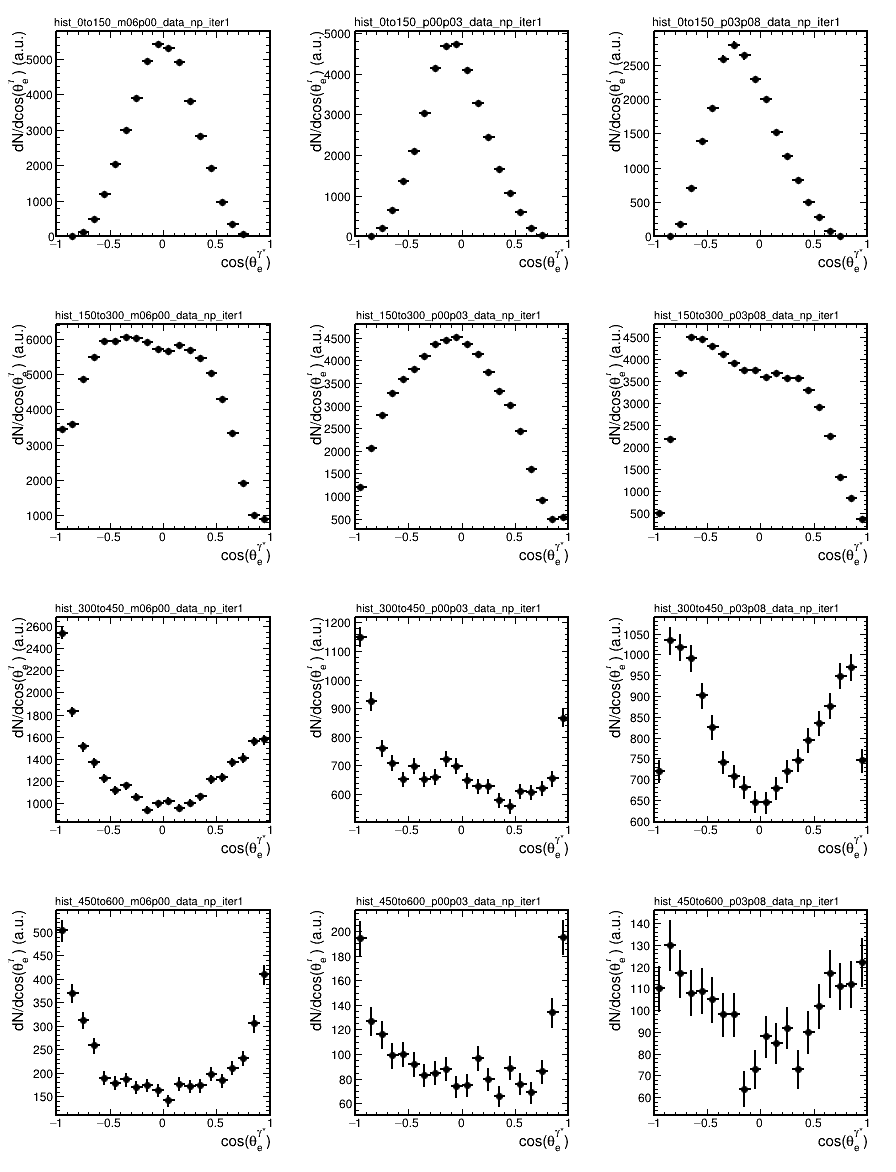

In [4]:
can4 = TCanvas("can4","can4",900,1200)
can4.Divide(3,4)
can4.Draw()
for i, hist in enumerate(histsData_np[0]):
    pad = can4.cd(i+1)
    set_pad(pad)
    if not isinstance(hist, list):
        hist.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        set_th1(hist, hist.GetXaxis().GetTitle(), f"dN/d{hist.GetXaxis().GetTitle()} (a.u.)", 
               505, 20, 0.8, 1)
        hist.Draw()
    else:
        print(hist)

can4.SaveAs(f'{DIR_NAME}/histsData_np.gif')

Info in <TCanvas::Print>: gif file results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr/base_hists_pi0_MC.gif has been created


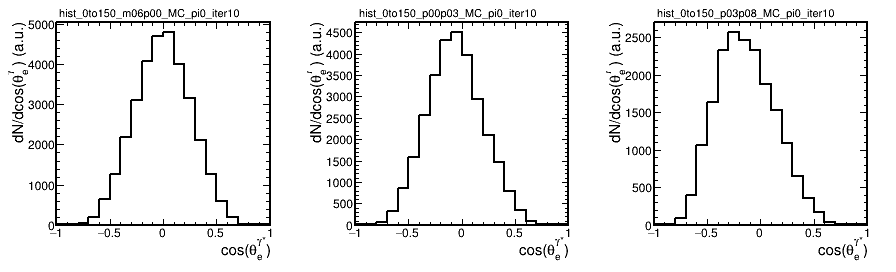

In [5]:
base_hists_pi0 = histMakerMC_pi0.builder.base_hists
can3 = TCanvas("can3","can3",900,300)
can3.Divide(3,1)
can3.Draw()
for i, hist in enumerate(base_hists_pi0[0]):
    if i < 3:
        pad = can3.cd(i+1)
        set_pad(pad)

        if not isinstance(hist, list):
            hist.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
            set_th1(hist, hist.GetXaxis().GetTitle(), f"dN/d{hist.GetXaxis().GetTitle()} (a.u.)", 
               505, 20, 0.8, 1)
            hist.Draw()
        else:
            print(hist)
can3.SaveAs(f"{DIR_NAME}/base_hists_pi0_MC.gif")

Info in <TCanvas::Print>: gif file results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr/base_hists_rho_MC.gif has been created


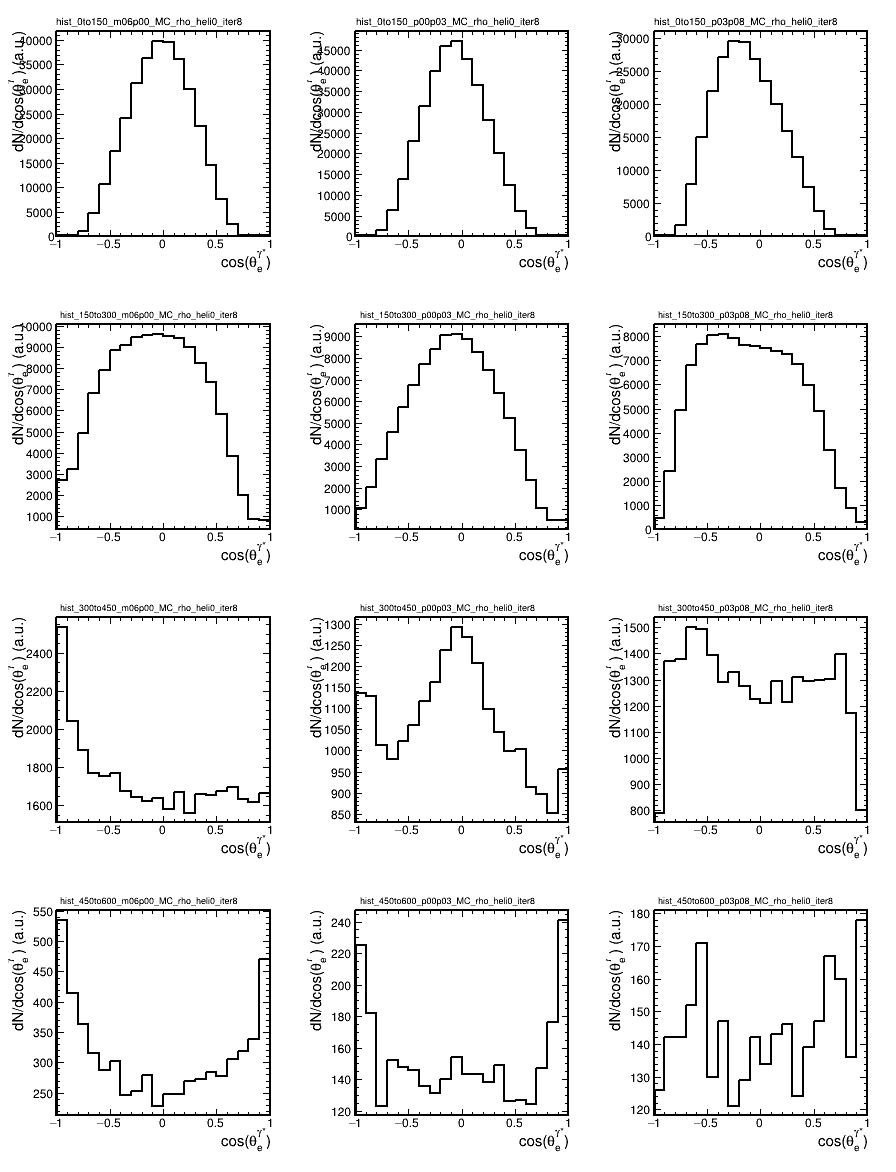

In [6]:
base_hists_rho = histMakerMC_rho.builder.base_hists
can5 = TCanvas("can5","can5",900,1200)
can5.Divide(3,4)
can5.Draw()
for i, hist in enumerate(base_hists_rho[0]):
    pad = can5.cd(i+1)
    set_pad(pad)
    if not isinstance(hist, list):
        hist.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        set_th1(hist, hist.GetXaxis().GetTitle(), f"dN/d{hist.GetXaxis().GetTitle()} (a.u.)", 
               505, 20, 0.8, 1)
        hist.Draw()
    else:
        print(hist)
can5.SaveAs(f'{DIR_NAME}/base_hists_rho_MC.gif')


In [7]:
import torch

torch.device("mps")
torch.manual_seed(0)

import gpytorch
import botorch

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)

from tqdm.notebook import tqdm

import warnings

In [8]:
TH1.SetDefaultSumw2()

gpytorch.settings.fast_pred_var()
gpytorch.settings.fast_pred_samples()

N_PARAMS = 1

In [9]:
torch.backends.mps.is_available()
#mps_device = torch.device("mps")
mps_device = torch.device("cpu")
bounds = torch.tensor([[-2, ],
                       [ 2, ]], dtype=torch.float)
bounds = bounds.to(mps_device)


xs = torch.linspace(bounds[0][0], bounds[1][0], 101)

In [10]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
# class GPModel(gpytorch.models.ApproximateGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=1)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        mean_x = mean_x.to(mps_device)
        covar_x = covar_x.to(mps_device)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def fit_gp_model(train_x, train_y, num_train_iters=500):
    train_x = train_x.to(mps_device)
    train_y = train_y.to(mps_device)

    # declare the GP
    noise = 1e-1

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise
    likelihood = likelihood.to(mps_device)
    model = model.to(mps_device)

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for j in range(num_train_iters):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model.cpu(), likelihood.cpu()

In [11]:
# TODO: Come back to standard version
#num_queries = 75
num_queries = 200
num_repeats = 1
num_samples = 20

In [12]:
# -2 is the default value when no feasible has been found
default_value = -1

def fit_bo(hist_index = 0):
    global bounds

    def objective(xx):
        def generator(xxx):
            for x in xxx:
                lambda_theta = x

                hists_mc = get_hist_maker_mc(hist_index).make_hists(lambda_theta)
                chi2, ndf = calc_one_chi2(hists_mc[0][hist_index], histsData_np[0][hist_index])
                allHistsMC.append(hists_mc[0][hist_index])
                if not chi2 or not ndf:
                    return torch.tensor([0])
                yield torch.tensor([1.0/(chi2 / ndf)])
        return torch.stack([a for a in generator(xx)])

    def one_starting_sample():
        result = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(N_PARAMS)
        return result

    feasible_incumbents = torch.ones((num_repeats, num_queries)) * default_value

    best_fs = []

    print(f"HIST INDEX: {hist_index}")
    for trial in range(num_repeats):
       # print("trial", trial)

        torch.manual_seed(trial)
       # train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(num_samples, 3)
       # while -2.0*train_x[0][0] - 1.0*train_x[0][2] < -2:
       #     train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(num_samples, 3)
        train_x = torch.stack([one_starting_sample() for _ in range(num_samples)])
        train_utility = objective(train_x).to(mps_device)
        train_x = train_x.to(mps_device)

        for j in tqdm(range(num_queries)):
            feasible_incumbents[trial, j] = train_utility.max()
            before_fit_gp = time()
            utility_model, utility_likelihood = fit_gp_model(
                train_x, train_utility.squeeze(-1)
            )
            after_fit_gp = time()
           # print("Fitting GP took " + str(after_fit_gp - before_fit_gp) + " seconds")
            best_f = train_utility.max()
            best_fs.append(best_f.item())
                
           # policy = botorch.acquisition.monte_carlo.qExpectedImprovement(
           # policy = botorch.acquisition.analytic.LogExpectedImprovement(
            policy = botorch.acquisition.logei.qLogExpectedImprovement(
          # policy = botorch.acquisition.analytic.LogProbabilityOfImprovement(
          # policy = botorch.acquisition.analytic.PosteriorMean(
                model=utility_model,
                best_f=train_utility.max(),
            ).to(mps_device)

            before_optimize_acqf = time()
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', category=RuntimeWarning)
                next_x, acq_val = botorch.optim.optimize_acqf(
                    policy,
                    bounds=bounds,
                    #q=5,
                    #num_restarts=5,
                    #raw_samples=400,
                    q=1,
                    num_restarts=40,
                    raw_samples=100,
                )
            after_optimize_acqf = time()
           # print("Optimizing ACQF took " + str(after_optimize_acqf - before_optimize_acqf) + " seconds")

            next_utility = objective(next_x).to(mps_device)

            train_x = torch.cat([train_x, next_x])
            train_utility = torch.cat([train_utility, next_utility])
    torch.save(feasible_incumbents, f"{DIR_NAME}/incumbents_" + str(hist_index) + ".pth")
    outfile = TFile(f"{DIR_NAME}/out_{hist_index}.root", "RECREATE")
    outfile.cd()
    for histogram in allHistsMC:
       # print ("Writing hist: ", hist.GetName())
        histogram.Write()
    for j, hists in enumerate(histsData_np):
        for k, histogram in enumerate(hists):
                histogram.Write()
               # print ("Writing hist: ", j, k, hist)
    outfile.Close()

    with torch.no_grad():
        predictive_distribution = utility_likelihood(utility_model(xs))
        acquisition_score = policy(xs.unsqueeze(1))

    lambda_thetas     = train_x.flatten()
    
    c = torch.stack((
        torch.arange(0,num_queries, dtype=int),
        lambda_thetas[0:num_queries],
        train_utility.squeeze()[0:num_queries],
        (feasible_incumbents==feasible_incumbents.max())[0],
        feasible_incumbents[0]
    ),0).transpose(-2,-1)
    torch.set_printoptions(precision=4,threshold=10_000, linewidth=120)
    sort_index = c[:, N_PARAMS + 1].sort()[1]
    c_sorted = c[sort_index]
    train_x_sorted = train_x[sort_index]

    return c_sorted, train_x_sorted, predictive_distribution

In [13]:
c_sorted_all = []
train_x_sorted_all = []
predictive_mean_all = []
predictive_lower_all = []
predictive_upper_all = []

for HIST_INDEX in range_used:
    allHistsMC = []
    if read_saved:
        c_sorted = torch.load(f"{DIR_NAME}/c_sorted_" + str(HIST_INDEX) + ".pth")
        train_x_sorted = torch.load(f"{DIR_NAME}/train_x_sorted_" + str(HIST_INDEX) + ".pth")
        predictive_distribution = torch.load(f"{DIR_NAME}/predictive_distribution_" + str(HIST_INDEX) + ".pth")

        file = TFile(f"{DIR_NAME}/out_{HIST_INDEX}.root", "read")
        names = [key.GetName() for key in file.GetListOfKeys()]
        names = [name for name in names if "MC" in name]
        for name in names:
            allHistsMC.append(file.Get(name))
    else:
        c_sorted, train_x_sorted, predictive_distribution = fit_bo(HIST_INDEX)
        print(c_sorted[-5:])
        
        torch.save(c_sorted, f"{DIR_NAME}/c_sorted_" + str(HIST_INDEX) + ".pth")
        torch.save(train_x_sorted, f"{DIR_NAME}/train_x_sorted_" + str(HIST_INDEX) + ".pth")
        torch.save(predictive_distribution, f"{DIR_NAME}/predictive_distribution_" + str(HIST_INDEX) + ".pth")

    predictive_mean = predictive_distribution.mean
    predictive_lower, predictive_upper = predictive_distribution.confidence_region()
    print("AFTER_READING: ", predictive_mean[100], predictive_lower[100], predictive_upper[100])

    c_sorted_all.append(c_sorted)
    train_x_sorted_all.append(train_x_sorted)
    predictive_mean_all.append(predictive_mean)
    predictive_lower_all.append(predictive_lower)
    predictive_upper_all.append(predictive_upper)



AFTER_READING:  tensor(0.0059) tensor(-0.0511) tensor(0.0629)
AFTER_READING:  tensor(0.0085) tensor(-0.0485) tensor(0.0655)
AFTER_READING:  tensor(0.0060) tensor(-0.0511) tensor(0.0630)
AFTER_READING:  tensor(0.0671) tensor(-0.2864) tensor(0.4205)
AFTER_READING:  tensor(0.0198) tensor(-0.0623) tensor(0.1018)
AFTER_READING:  tensor(0.0761) tensor(-0.2902) tensor(0.4424)
AFTER_READING:  tensor(0.0343) tensor(-0.0472) tensor(0.1159)
AFTER_READING:  tensor(0.0504) tensor(-0.0315) tensor(0.1322)
AFTER_READING:  tensor(0.0428) tensor(-0.0388) tensor(0.1245)
AFTER_READING:  tensor(0.3571) tensor(0.2759) tensor(0.4383)
AFTER_READING:  tensor(0.2265) tensor(0.0759) tensor(0.3770)
AFTER_READING:  tensor(0.3169) tensor(0.0612) tensor(0.5725)


In [14]:
from ipywidgets import interact, Layout, IntSlider, FloatSlider
import numpy as np

axis_title = r"$cos(\theta_e^{\gamma*})$"

def oneplot(ax, tensor, title):
        
        global xs
        
       # pos = ax.plot(xs, tensor, ymin=0, ymax=tensor.max())
        pos = ax.plot(xs, tensor)
       # ax.set_aspect((extent[1]-extent[0])/(extent[3]-extent[2]))
        ax.set_title(title)
        ax.set_xlabel(axis_title)

can_cmp_ind = 0

def plotComparison(can, pad_nr1, pad_nr2, histMC, histData, hist_index, pull_title):
   # print(f"PLOTTING: {histMC.GetName()} and {histData.GetName()}")
    global can_cmp_ind

    curr_bin = bins[hist_index]
    title = f"{curr_bin.m_min} < #it{{M}}_{{ee}} < {curr_bin.m_max}, {curr_bin.z_min} < cos(#theta^{{CM}}_{{#gamma*}}) < {curr_bin.z_max}"
    
    pad = can.cd(pad_nr1)
    set_pad(pad)
    pad.SetRightMargin(0.16)
    histData.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
    histData.SetTitle(title)
    set_th1(histData, histData.GetXaxis().GetTitle(), f"dN/d{histData.GetXaxis().GetTitle()} (a.u.)", 
               505, 20, 0.8, 1)
    histData.Draw()
    histMC.Scale(histData.Integral()/histMC.Integral())
    histMC.SetLineColor(2)
    histMC.Draw("SAMEHIST")
    pad = can.cd(pad_nr2)
    set_pad(pad)
    pad.SetRightMargin(0.16)
    hdiff = diff_hist(histMC, histData)
    hdiff.SetTitle(pull_title)
    set_th1(hdiff, hdiff.GetXaxis().GetTitle(), "Pull value", 505, 20, 0.8, 2)
    hdiff.Draw("HIST")
    can.Update()
    can.Modified()
    can.Update()
    
    return hdiff

def xAxisProperties(histMC, histData):
    n = 0
    meanX2 = 0
    for i, (c1, c2) in enumerate(zip(histMC, histData)):
        if c1 != 0 and c2 != 0:
            n = n + 1
            meanX2 = meanX2 + math.pow(histMC.GetBinCenter(i+1), 2)
    if n > 0:
        meanX2 = meanX2 / n
    varX2 = 0
    sigma2 = 0
    for i, (c1, c2) in enumerate(zip(histMC, histData)):
        if c1 != 0 and c2 != 0:
            center = histData.GetXaxis().GetBinCenter(i+1)
            varX2 = varX2 + math.pow(math.pow(center, 2) - meanX2, 2)
            sigma2 = sigma2 + math.pow((c2 - c1)/c1 , 2)
    if n > 2:
        sigma2 = sigma2/(n-2)
    return n, meanX2, varX2, sigma2

In [15]:
def bin_index(x, min, max):
        return int((x-min)/(max-min)*101)

def covariance_fit_scipy(predictive_mean, predictive_lower, predictive_upper, best, HIST_INDEX, ax):
    def gaus1d(x, A, mean_x, sigma_x):
        x = x - mean_x
        z = A * np.exp( -0.5 * (x/sigma_x) ** 2 )
        return z
    def gaus1d_offset(x, A, mean_x, sigma_x, offset):
        x = x - mean_x
        z = offset + A * np.exp( -0.5 * (x/sigma_x) ** 2 )
        return z

    def fit_1d(ax):
        curr_bin = bins[HIST_INDEX]
        title = f"{curr_bin.m_min} < $M_{{ee}}$ < {curr_bin.m_max}, {curr_bin.z_min} < $cos(\\theta^{{CM}}_{{\gamma*}})$ < {curr_bin.z_max}"
        
        mean_x = best[0].item()

        scale1 = bounds[1][0].item()
        scale2 = bounds[1][0].item()
        proj_min_X = bounds[0][0].item()
        proj_max_X = bounds[1][0].item()

        proj = predictive_mean
        proj_lower = predictive_lower
        proj_upper = predictive_upper

       # xmin_ind = max(0,   bin_index(mean_x, proj_min_X, proj_max_X)-50)
       # xmax_ind = min(100, bin_index(mean_x, proj_min_X, proj_max_X)+50)
        xmin_ind = 0
        xmax_ind = 100
        xmin = proj_min_X + xmin_ind / 101. * (proj_max_X - proj_min_X)
        xmax = proj_min_X + (xmax_ind + 1) / 101. * (proj_max_X - proj_min_X)

        x = np.linspace(-2, 2, 101)

        proj1 = proj[xmin_ind:xmax_ind]
        print("range ", xmin_ind, xmax_ind, xmin, xmax)
    
       # initial_guess = (1.0, mean_x, 0.2*(proj_max_X-proj_min_X))
        initial_guess = (1.0, mean_x, 0.2*(proj_max_X-proj_min_X), 0)
        eps = 0.001
       # param_bounds = ([0,mean_x-eps,0],[np.inf,mean_x+eps,2])
       # if mean_x >= 1.0:
       #     param_bounds = ([0,mean_x-eps,0],[np.inf,2,2])
        param_bounds = ([0,mean_x-eps,0,-np.inf],[np.inf,mean_x+eps,2,np.inf])
        if mean_x >= 1.0:
            param_bounds = ([0,mean_x-eps,0,-np.inf],[np.inf,2,2,np.inf])
       # ax.plot(x, proj, label="Estimated values")
        ax.plot(x, proj)
        ax.fill_between(x, proj_lower, proj_upper, alpha=0.5)
        ax.plot(x, proj, label="Estimated values")
        ax.set_title(title)
        ax.set_xlabel(r"$\lambda_{\theta}$")
        ax.set_ylabel("ndf$/\chi^2$")
        ax.set_ylim(0,1.5*proj_upper.max())
        try:
            popt, pcov = opt.curve_fit(gaus1d_offset, x[xmin_ind:xmax_ind], proj1, p0 = initial_guess, bounds=param_bounds, maxfev=2000)
            fit_result = gaus1d_offset(x, *(popt))
    
            ax.plot(x, fit_result, label="Gaussian fit")
           # ax.set_ylim([0,2*predictive_upper.max()])
           # plt.rc('axes', titlesize=8)
           # plt.rc('axes', labelsize=8) 
           # plt.rc('xtick', labelsize=8)
           # plt.rc('ytick', labelsize=8)
            ax.legend()
        except RuntimeError as e:
            print(f"There was an exception {e}")
            popt, pcov = None, None
        return popt, pcov

   # params0, _ = fit_1d(ax[1][0])
    params0, _ = fit_1d(ax)
    plt.savefig(f"{DIR_NAME}/chi2_best_{HIST_INDEX}.png", bbox_inches="tight")

    try:
        return params0[1], params0[2]
    except:
        return None

#2 [[<cppyy.gbl.TH1F object at 0x6c8114820>, <cppyy.gbl.TH1F object at 0x6c813bc10>, <cppyy.gbl.TH1F object at 0x6c813c000>, <cppyy.gbl.TH1F object at 0x6c813c3f0>, <cppyy.gbl.TH1F object at 0x6c813c7e0>, <cppyy.gbl.TH1F object at 0x6c813cbd0>, <cppyy.gbl.TH1F object at 0x6c813cfc0>, <cppyy.gbl.TH1F object at 0x6c813d3b0>, <cppyy.gbl.TH1F object at 0x6c813d7a0>, <cppyy.gbl.TH1F object at 0x6c813db90>, <cppyy.gbl.TH1F object at 0x6c813df80>, <cppyy.gbl.TH1F object at 0x6c813e370>], [<cppyy.gbl.TH1F object at 0x669308b30>, <cppyy.gbl.TH1F object at 0x6693094b0>], [<cppyy.gbl.TH1F object at 0x669308f20>, <cppyy.gbl.TH1F object at 0x669309a40>]]
#2 [[<cppyy.gbl.TH1F object at 0x6c40cd8d0>, <cppyy.gbl.TH1F object at 0x6c40cdcc0>, <cppyy.gbl.TH1F object at 0x6c40ce0b0>, <cppyy.gbl.TH1F object at 0x6c40ce4a0>, <cppyy.gbl.TH1F object at 0x6c40ce890>, <cppyy.gbl.TH1F object at 0x6c40cec80>, <cppyy.gbl.TH1F object at 0x6c40cf070>, <cppyy.gbl.TH1F object at 0x6c40cf460>, <cppyy.gbl.TH1F object at

Info in <TCanvas::Print>: gif file results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr/comparison_0.gif has been created
Info in <TCanvas::Print>: gif file results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr/comparison_1.gif has been created
Info in <TCanvas::Print>: gif file results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr/comparison_2.gif has been created
Info in <TCanvas::Print>: gif file results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr/comparison_3.gif has been created
Info in <TCanvas::Print>: gif file results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr/comparison_4.gif has been created
Info in <TCanvas::Print>: gif file results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr/comparison_5.gif has been created
Info in <TCanvas::Print>: gif file results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr/comparison_6.gif has been created
Info in <TCanvas::Print>: gif file results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr/comparison_7.gif has been created
Info in <TCanvas::Print>

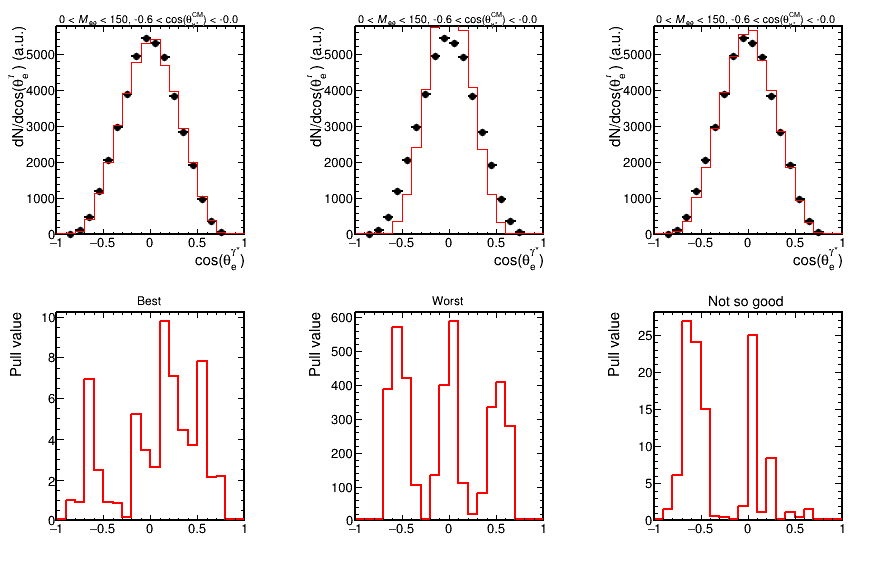

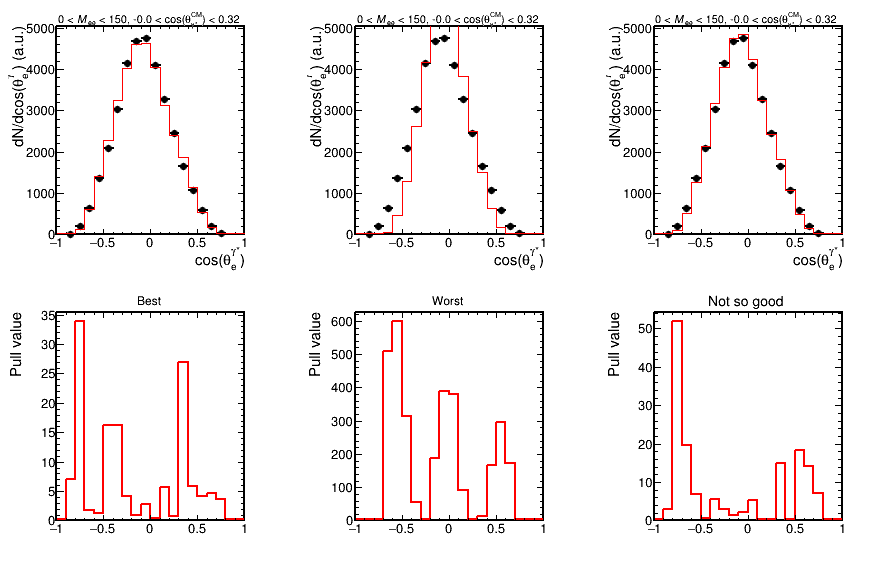

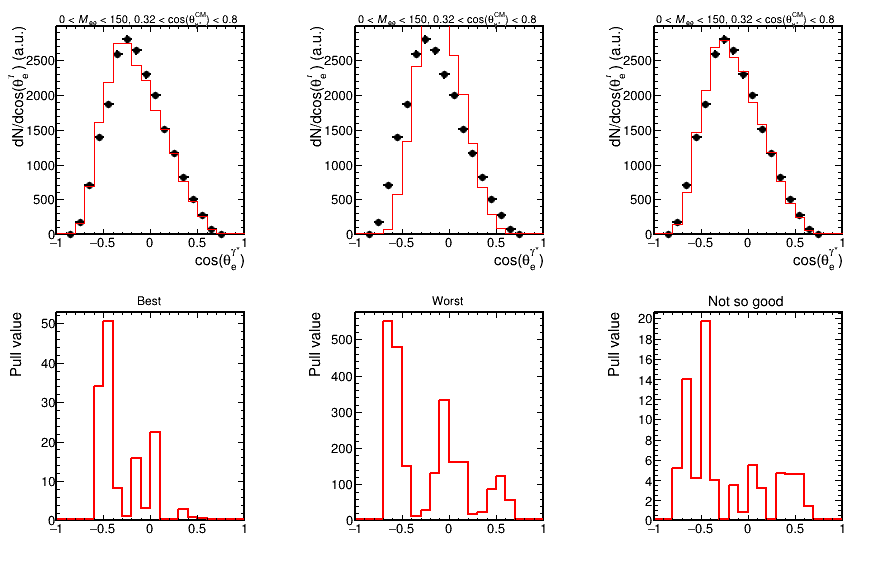

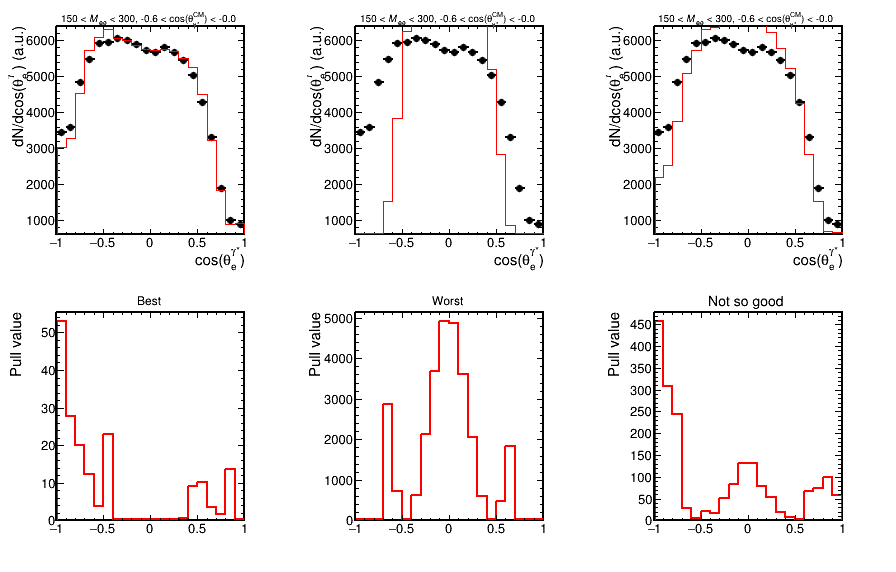

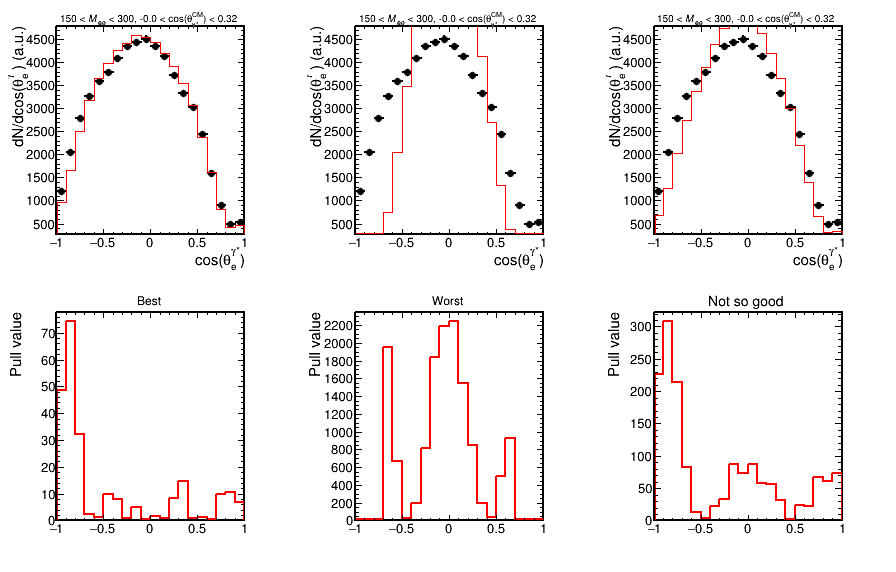

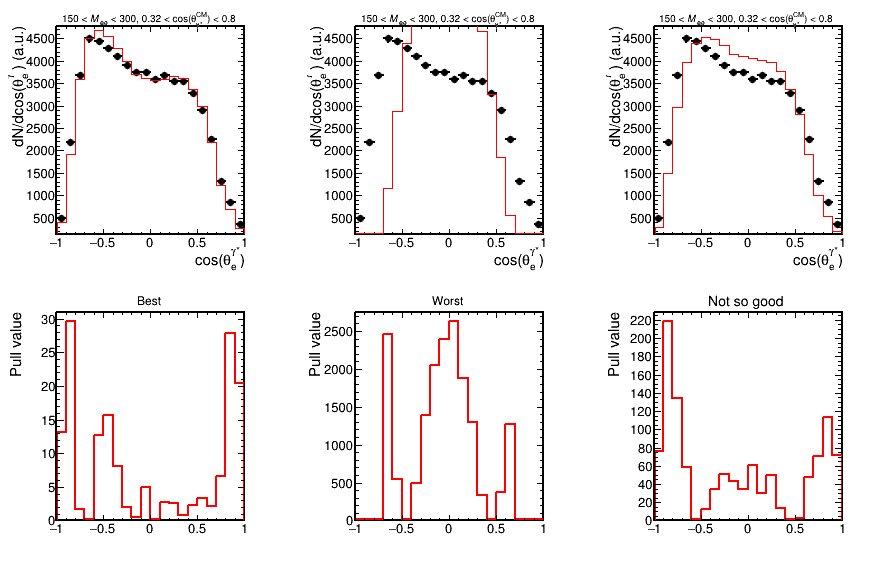

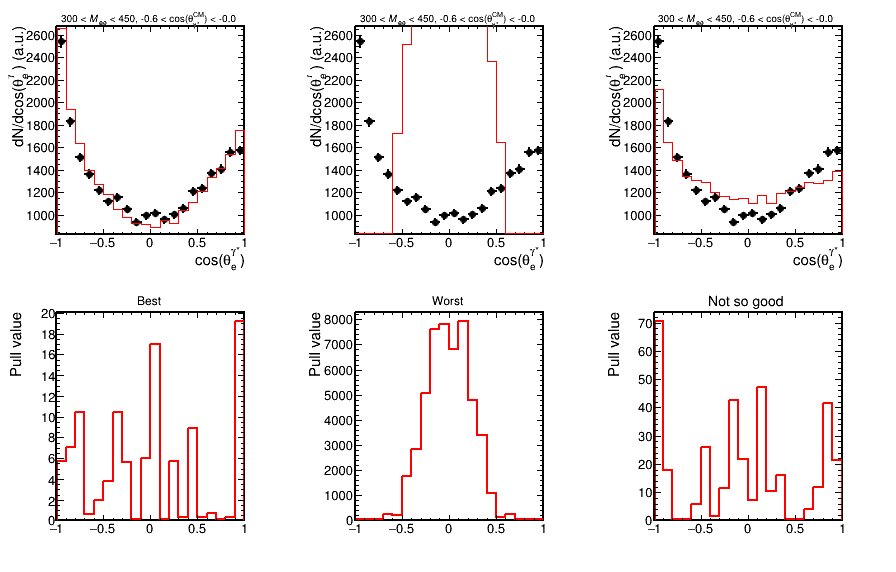

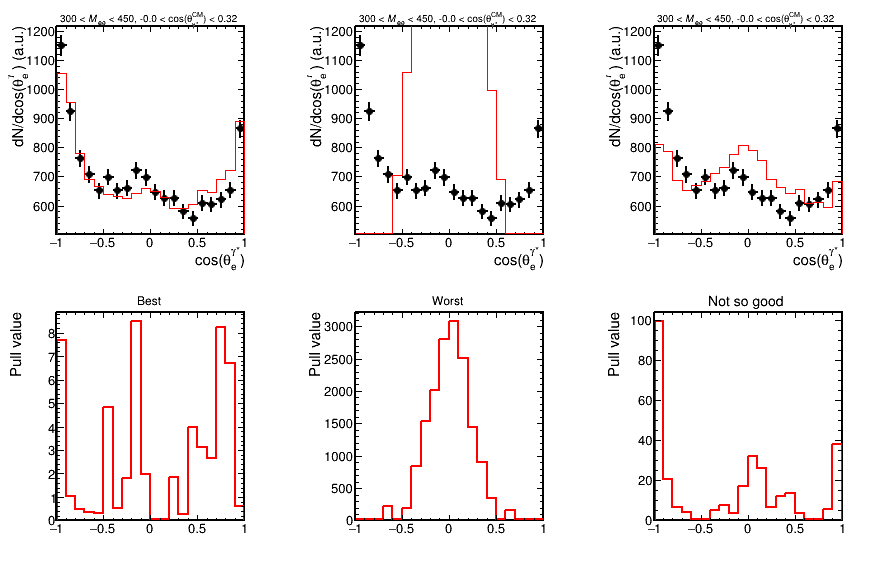

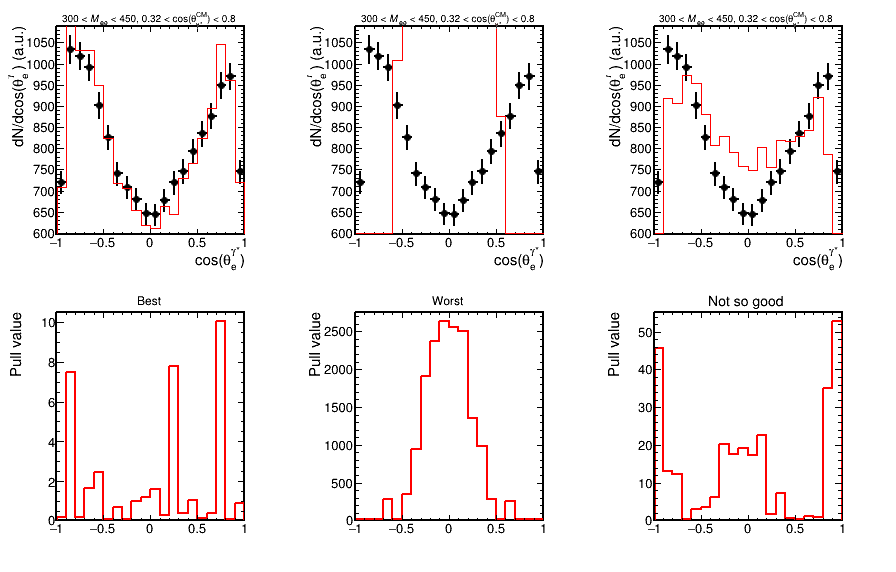

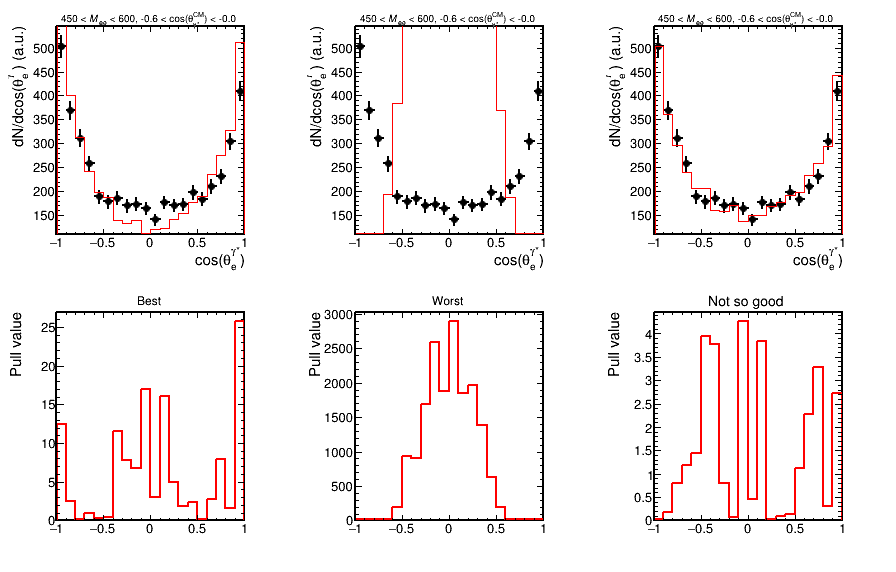

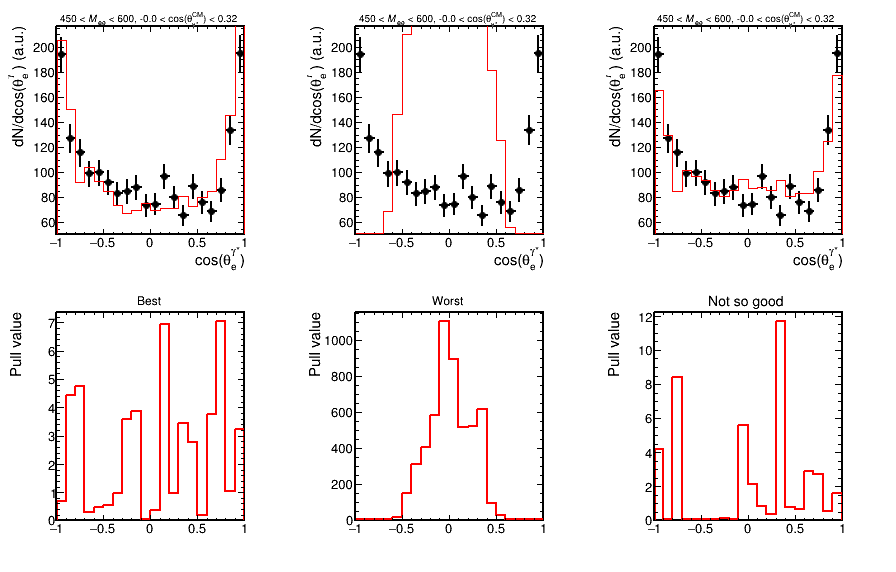

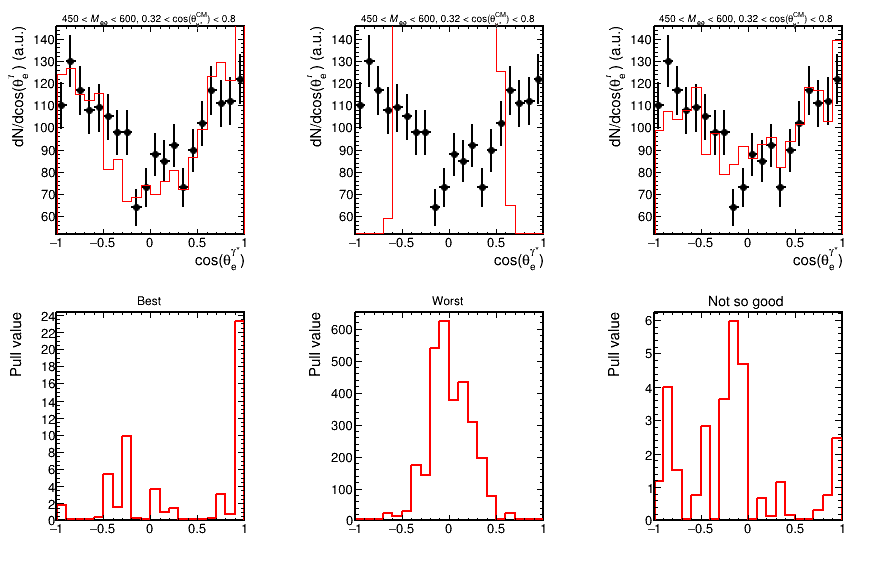

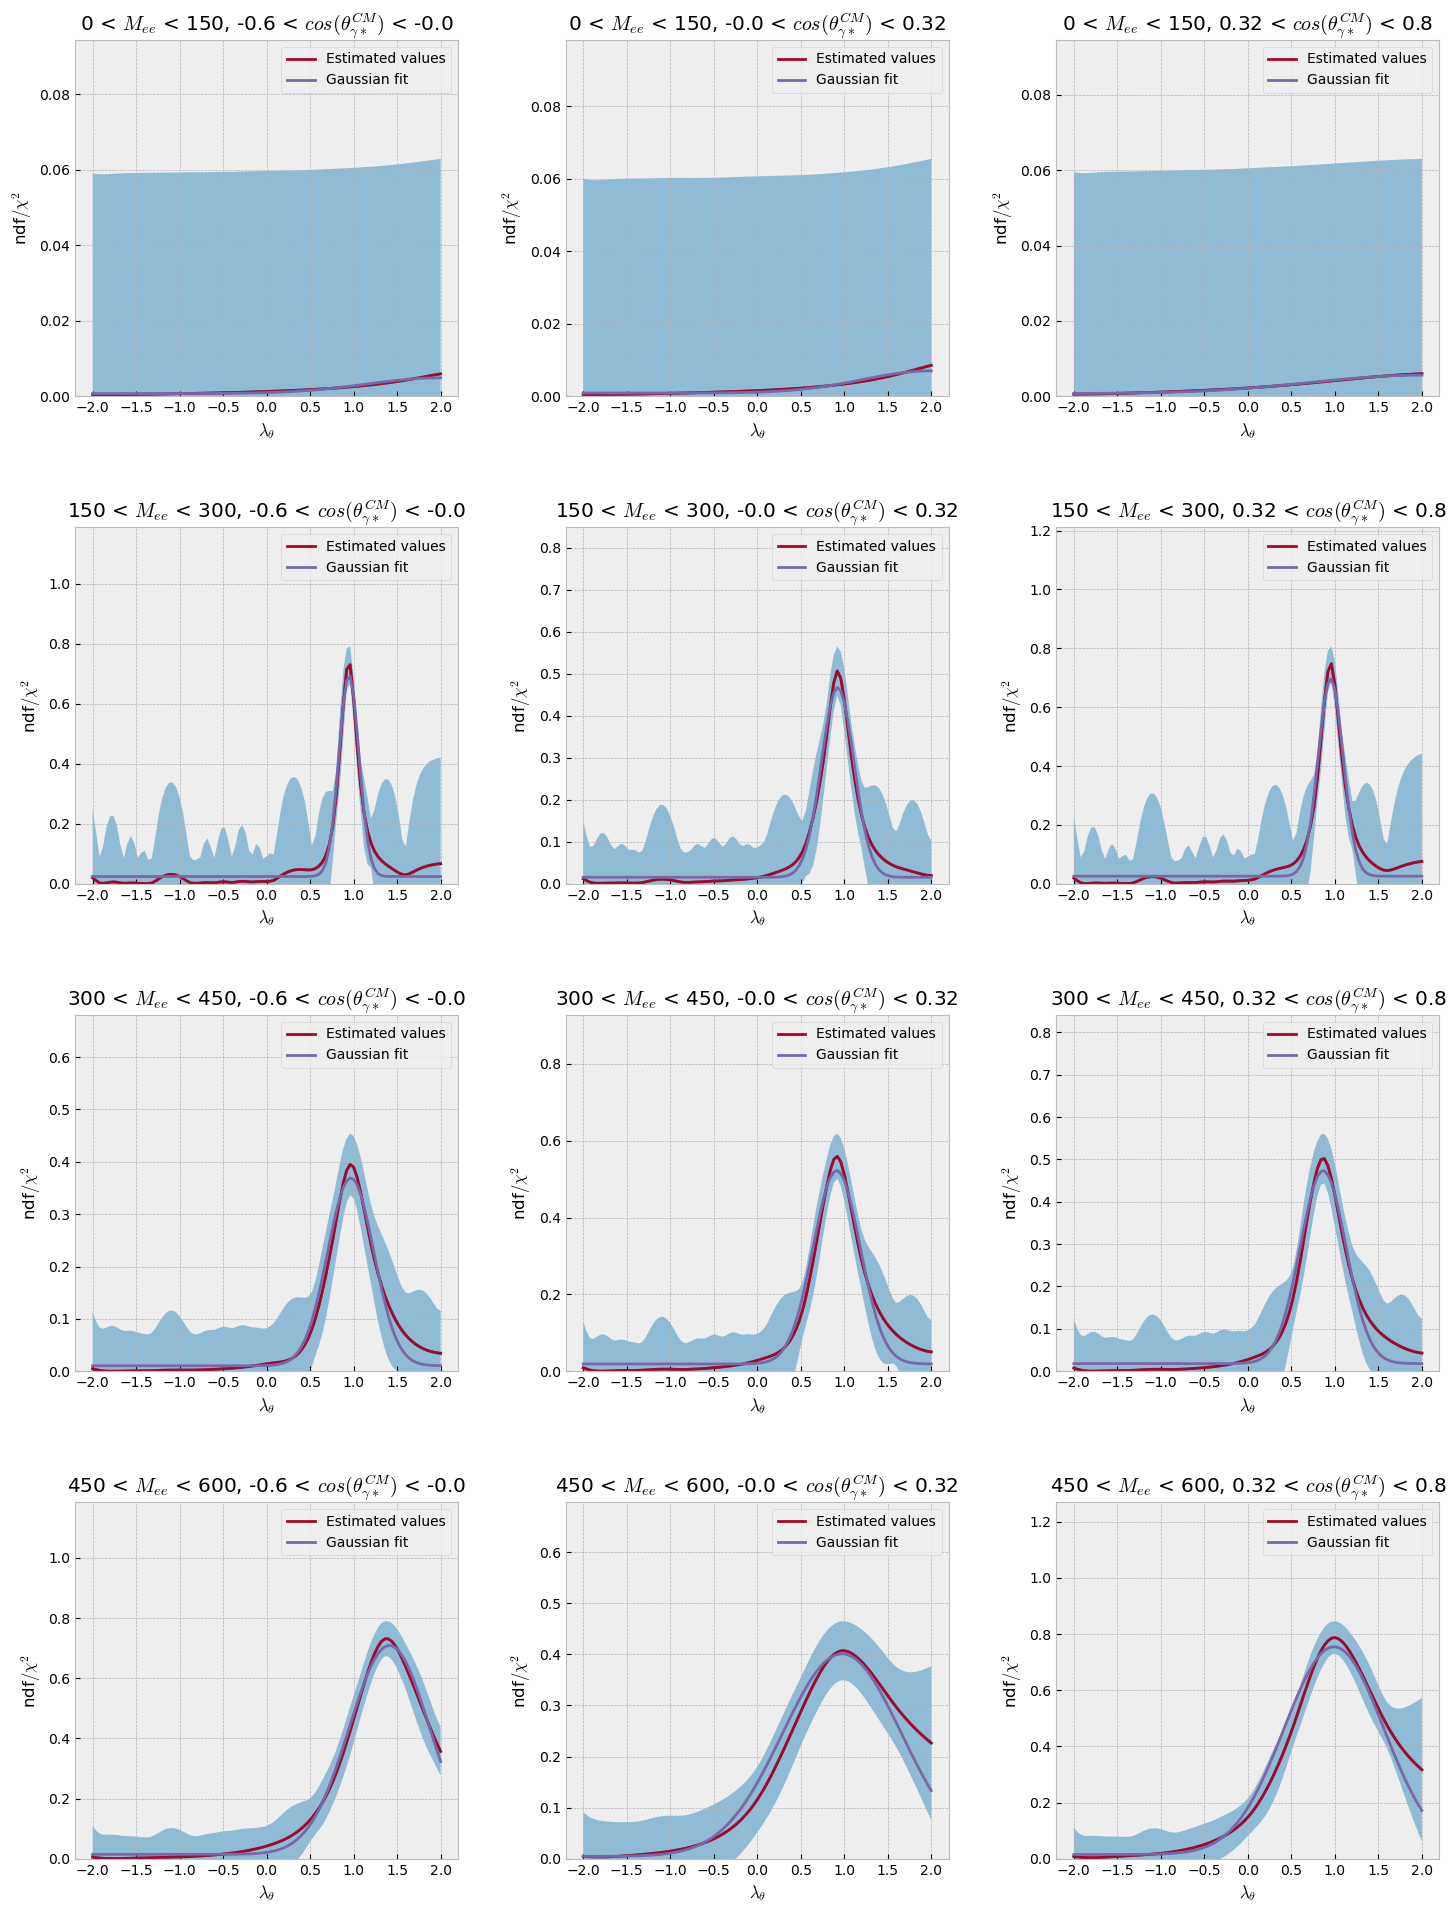

In [16]:

with open(f'{DIR_NAME}/results.txt', 'w') as fout:
    canvases = []
    hdiffs = []
    hmodels = []
    
    fig, ax = plt.subplots(nrows=4, ncols=3)
    fig.tight_layout()
    fig.set_figheight(20)
    fig.set_figwidth(15)
   # fig, ax = plt.subplots(nrows=1, ncols=1)
    
    for HIST_INDEX in range_used:

        c_sorted = c_sorted_all[HIST_INDEX - range_used.start]
        train_x_sorted = train_x_sorted_all[HIST_INDEX - range_used.start]
        predictive_mean = predictive_mean_all[HIST_INDEX - range_used.start]
        predictive_lower = predictive_lower_all[HIST_INDEX - range_used.start]
        predictive_upper = predictive_upper_all[HIST_INDEX - range_used.start]
        predictive_mean_2 = predictive_mean - predictive_mean.min()

       # ax = plt.axes()
       # fig, ax = plt.subplots(nrows=1, ncols=1)
        lambda_theta = train_x_sorted[-1]
        bestHistsMC = get_hist_maker_mc(HIST_INDEX).make_hists(lambda_theta)
        hmodels.append(bestHistsMC[0][HIST_INDEX])
        
        can1 = TCanvas(f"can_cmp_{HIST_INDEX}","can",900,600)
        can1.Divide(3,2)
        can1.Draw()        
        canvases.append(can1)
        
        hdiff1 = plotComparison(can1, 1, 4, bestHistsMC[0][HIST_INDEX], histsData_np[0][HIST_INDEX], HIST_INDEX, "Best")
        hdiffs.append(hdiff1)
        
        lambda_theta = train_x_sorted[0]
        worstHistsMC = get_hist_maker_mc(HIST_INDEX).make_hists(lambda_theta)
        hmodels.append(worstHistsMC[0][HIST_INDEX])
        hdiff2 = plotComparison(can1, 2, 5, worstHistsMC[0][HIST_INDEX], histsData_np[0][HIST_INDEX], HIST_INDEX, "Worst")
        hdiffs.append(hdiff2)

        shift = 0.75
        if train_x_sorted[-1] > shift - 1:
            diffToBest = torch.tensor([-shift])
        else:
            diffToBest = torch.tensor([+shift])
        lambda_theta = train_x_sorted[-1] + diffToBest
        notSoGoodHistsMC = get_hist_maker_mc(HIST_INDEX).make_hists(lambda_theta)
        hmodels.append(notSoGoodHistsMC[0][HIST_INDEX])
        hdiff22 = plotComparison(can1, 3, 6, notSoGoodHistsMC[0][HIST_INDEX], histsData_np[0][HIST_INDEX], HIST_INDEX, "Not so good")
        hdiffs.append(hdiff22)

        can1.SaveAs(f"{DIR_NAME}/comparison_{HIST_INDEX}.gif")

        mean, width = covariance_fit_scipy(predictive_mean,predictive_lower,predictive_upper,train_x_sorted[-1],HIST_INDEX,ax[HIST_INDEX // 3][HIST_INDEX % 3])

    
        n, meanX2, varX2, sigma2 = xAxisProperties(bestHistsMC[0][HIST_INDEX], histsData_np[0][HIST_INDEX])
        errB0 = math.sqrt(sigma2 * (1/n + meanX2 * meanX2 / varX2))
        errB1 = math.sqrt(sigma2 / varX2)
        ratio_error = ratio_err(c_sorted[-1][1].item(), 1, errB1, errB0)

        try:
            print(str(HIST_INDEX) + ". Final result: lambda_theta = ", c_sorted[-1][1].item(), " +- ", ratio_error)
            print(str(HIST_INDEX) + ". Final result: lambda_theta = ", c_sorted[-1][1].item(), " +- ", ratio_error, file=fout)
        except:
            print(str(HIST_INDEX) + ". Final result: lambda_theta = ", c_sorted[-1][1].item())
            print(str(HIST_INDEX) + ". Final result: lambda_theta = ", c_sorted[-1][1].item(), file=fout)


#2 [[<cppyy.gbl.TH1F object at 0x12c442a00>, <cppyy.gbl.TH1F object at 0x12c442df0>, <cppyy.gbl.TH1F object at 0x12c4431e0>, <cppyy.gbl.TH1F object at 0x12c4403d0>, <cppyy.gbl.TH1F object at 0x12c444500>, <cppyy.gbl.TH1F object at 0x12c4448f0>, <cppyy.gbl.TH1F object at 0x12c444ce0>, <cppyy.gbl.TH1F object at 0x12c4450d0>, <cppyy.gbl.TH1F object at 0x12c4454c0>, <cppyy.gbl.TH1F object at 0x12c4458b0>, <cppyy.gbl.TH1F object at 0x12c445ca0>, <cppyy.gbl.TH1F object at 0x12c446090>], [<cppyy.gbl.TH1F object at 0x13fbfba60>, <cppyy.gbl.TH1F object at 0x13fbfc580>], [<cppyy.gbl.TH1F object at 0x13fbfbff0>, <cppyy.gbl.TH1F object at 0x13fbfcb10>]]
#2 [[<cppyy.gbl.TH1F object at 0x12c446a70>, <cppyy.gbl.TH1F object at 0x12c446e60>, <cppyy.gbl.TH1F object at 0x12c447250>, <cppyy.gbl.TH1F object at 0x12c447640>, <cppyy.gbl.TH1F object at 0x12c447a30>, <cppyy.gbl.TH1F object at 0x12c447e20>, <cppyy.gbl.TH1F object at 0x12c448210>, <cppyy.gbl.TH1F object at 0x12c448600>, <cppyy.gbl.TH1F object at

Info in <TCanvas::Print>: gif file results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr/fit_classic.gif has been created
Info in <TCanvas::Print>: pdf file results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr/fit_classic.pdf has been created


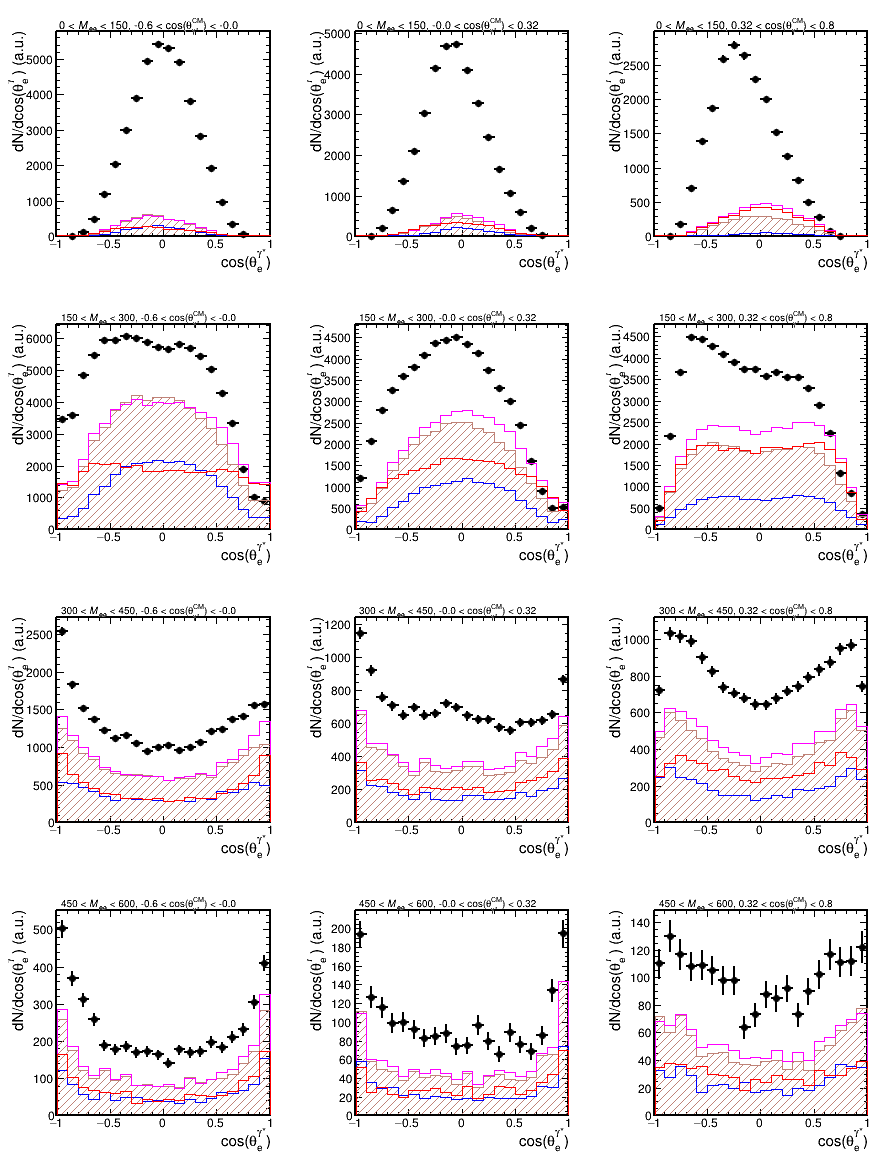

In [17]:
histsDataCorrs = []
hmodel_null = histMakerMC_rho.make_hists((0.0))
hmodel_null_mix = histMakerMC_mix.make_hists((0.0))
hmodel_null_pi0 = histMakerMC_pi0.make_hists((0.0))
hmodel_null_4pi_heli0 = histMakerMC_rho_4pi_heli0.make_hists((0.0))
hmodel_null_4pi_heli1 = histMakerMC_rho_4pi_heli1.make_hists((0.0))
hmodel_null_heli1 = histMakerMC_rho_heli1.make_hists((0.0))

pol2s = []
paveTexts = []
histsAvg = []
kfactors = []

cc4 = TCanvas("cc4","cc4",900,1200)
cc4.Divide(3,4)
cc4.Draw()

cck = TCanvas("cck","cck",900,1200)
cck.Divide(3,4)

csig = TCanvas("csig","csig",900,1200)
csig.Divide(3,4)

cacc = TCanvas("cacc","cacc",900,1200)
cacc.Divide(3,4)

for i, hist in enumerate(histsData_np[0]):
    
    if not isinstance(hist, list):

        hist_pp = histsData_pp[0][i]
        hist_nn = histsData_nn[0][i]
        
        if symmetrize_explicit:
            symmetrize(hist)
            symmetrize(hist_pp)
            symmetrize(hist_nn)
        
        histAvg = geom_avg1d(hist_pp, hist_nn, 0.2)
        histsAvg.append(histAvg)

        
        histCorr = hist.Clone(hist.GetName() + "_corr")
        histsDataCorrs.append(histCorr)
        histCorr.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        
        pad = cc4.cd(i+1)
        set_pad(pad)       
       
        hist_np_mix = histsData_np_mix[0][i]
        hist_pp_mix = histsData_pp_mix[0][i]
        hist_nn_mix = histsData_nn_mix[0][i]

        if symmetrize_explicit:
            symmetrize(hist_np_mix)
            symmetrize(hist_pp_mix)
            symmetrize(hist_nn_mix)

        histAvg_mix = geom_avg1d(hist_pp_mix, hist_nn_mix, 0.2)
        hist_np_mix.Divide(histAvg_mix)
        hist_np_mix.Scale(2)
        kfactors.append(hist_np_mix)

        pad = cck.cd(i+1)
        set_pad(pad)

        hist_np_mix.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        
        set_th1(hist_np_mix, histCorr.GetXaxis().GetTitle(), f"dN/d{histCorr.GetXaxis().GetTitle()} (a.u.)", 
               505, 20, 0.8, 1)
        hist_pp_mix.SetLineColor(2)
        hist_nn_mix.SetLineColor(4)
        hist_pp_mix.SetMarkerColor(2)
        hist_nn_mix.SetMarkerColor(4)
        hist_np_mix.Draw()
        hist_pp_mix.Draw("SAME")
        hist_nn_mix.Draw("SAME")
        hist_np_mix.SetMinimum(0)
         
        pad = cc4.cd(i+1)
        set_pad(pad)       
        
        histAvg_withK = histAvg.Clone(histAvg.GetName() + "_withK")
        histsAvg.append(histAvg_withK)
        histAvg_withK.Multiply(hist_np_mix)
        
        histAvg_withK.SetFillStyle(3004)
        histAvg_withK.SetFillColor(45)
        histAvg_withK.SetLineColor(45)
        histAvg.SetLineColor(6)
        hist_pp.SetLineColor(4)
        hist_nn.SetLineColor(2)
                
        set_th1(hist, histCorr.GetXaxis().GetTitle(), f"dN/d{histCorr.GetXaxis().GetTitle()} (a.u.)", 
               505, 20, 0.8, 1)
        hist.SetMinimum(0)
        hist.Draw()
        histAvg_withK.Draw("SAMEHIST")
        histAvg.Draw("SAMEHIST")
        hist_pp.Draw("SAMEHIST")
        hist_nn.Draw("SAMEHIST")
        
        pad = csig.cd(i+1)
        set_pad(pad)     

        hist_model = hmodel_null_mix[0][i]
        if not event_mixing:
            if i < 3:
                hist_model = hmodel_null_pi0[0][i]
            else:
                hist_model = hmodel_null[0][i]
        if symmetrize_explicit:
            symmetrize(hist_model)

        # histCorr.Add(histAvg_withK,-1)
        histCorr.Divide(hist_model)
        
        # if symmetrize_explicit:    
        #     symmetrize(histCorr)

        fit = TF1(f"fit_{i}", "[0]*(1+[1]*x*x)",-1,1)
        fit.SetParameters(1, 1)
        
        histCorr.Fit(fit,"Q")
        pol2s.append(fit)
    
        set_th1(histCorr, histCorr.GetXaxis().GetTitle(), f"dN/d{histCorr.GetXaxis().GetTitle()} (a.u.)", 
               505, 20, 0.8, 1)
        histCorr.Draw()
        if i < 3:
            # histCorr.GetYaxis().SetRangeUser(0,2.5)
            histCorr.GetYaxis().SetRangeUser(0,20)
        else:
            # histCorr.GetYaxis().SetRangeUser(0,1.25)    
            histCorr.GetYaxis().SetRangeUser(0,2)    
        histCorr.SetMinimum(0)
        
        caption = f"#lambda_{{#theta}} = {fit.GetParameter(1):.2f} #pm {fit.GetParError(1):.2f}"
        paveText = set_opt_text(caption, 0.25,0.76,0.675,0.88, 2, 0.04)
        paveTexts.append(paveText)

        pad = cacc.cd(i+1)
        set_pad(pad)

        # hacc_heli0 = hist.Clone(hist.GetName() + "_acc_heli0")
        # hacc_heli1 = hist.Clone(hist.GetName() + "_acc_heli1")
        
        hacc_heli0 = hmodel_null[0][i]
        hacc_heli1 = hmodel_null_heli1[0][i]

        hist_4pi_heli0 = hmodel_null_4pi_heli0[0][i]
        hist_4pi_heli1 = hmodel_null_4pi_heli1[0][i]
        
        hacc_heli0.Divide(hist_4pi_heli0)
        hacc_heli1.Divide(hist_4pi_heli1)
        
        hacc_heli1.SetMinimum(0)
        hacc_heli1.Draw("HIST")
        hacc_heli0.Draw("SAME HIST")

    else:
        print(hist)

cc4.SaveAs(f"{DIR_NAME}/fit_classic.gif")
cc4.SaveAs(f"{DIR_NAME}/fit_classic.pdf")
    


Info in <TCanvas::Print>: gif file results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr/kfactor.gif has been created
Info in <TCanvas::Print>: gif file results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr/signal.gif has been created


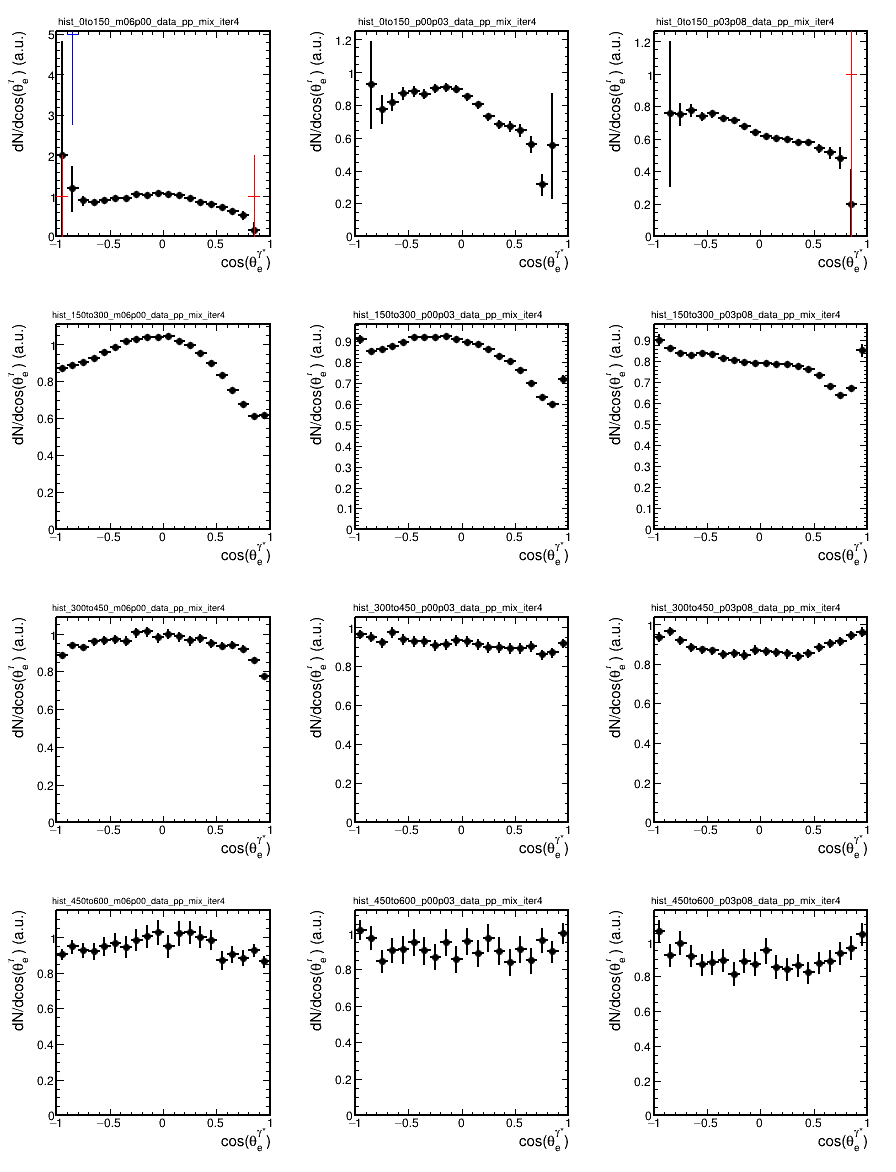

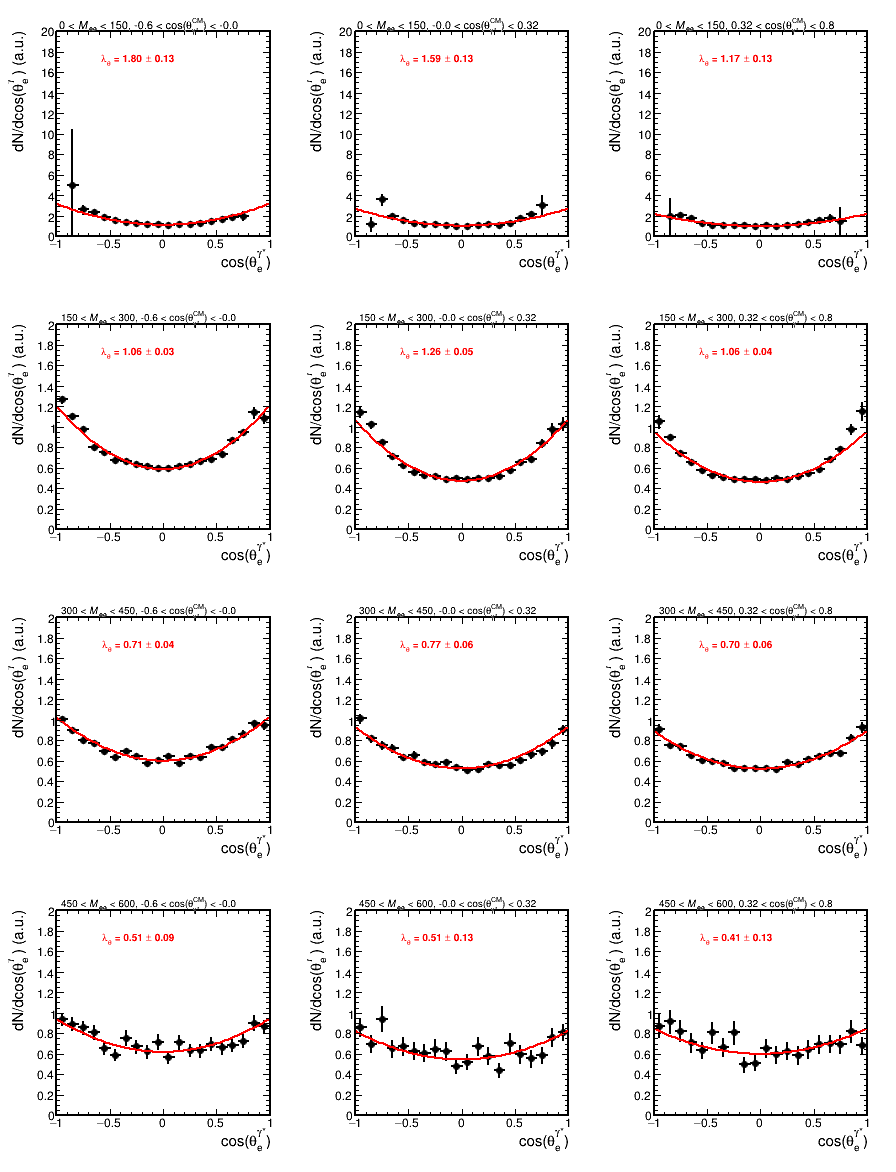

In [18]:
cck.Draw()
cck.SaveAs(f"{DIR_NAME}/kfactor.gif")

csig.Draw()
csig.SaveAs(f"{DIR_NAME}/signal.gif")

#2 [[<cppyy.gbl.TH1F object at 0x12c7b79e0>, <cppyy.gbl.TH1F object at 0x12c7b7dd0>, <cppyy.gbl.TH1F object at 0x12c7b81c0>, <cppyy.gbl.TH1F object at 0x12c7b85b0>, <cppyy.gbl.TH1F object at 0x12c7b89a0>, <cppyy.gbl.TH1F object at 0x12c7b8d90>, <cppyy.gbl.TH1F object at 0x12c7b9180>, <cppyy.gbl.TH1F object at 0x12c7b9570>, <cppyy.gbl.TH1F object at 0x12c7b9960>, <cppyy.gbl.TH1F object at 0x12c7b9d50>, <cppyy.gbl.TH1F object at 0x12c7ba140>, <cppyy.gbl.TH1F object at 0x12c7ba530>], [<cppyy.gbl.TH1F object at 0x13fbfba60>, <cppyy.gbl.TH1F object at 0x13fbfc580>], [<cppyy.gbl.TH1F object at 0x13fbfbff0>, <cppyy.gbl.TH1F object at 0x13fbfcb10>]]
#2 [[<cppyy.gbl.TH1F object at 0x6c49926d0>, <cppyy.gbl.TH1F object at 0x6c4992ac0>, <cppyy.gbl.TH1F object at 0x6c4999cc0>, <cppyy.gbl.TH1F object at 0x6c499a0b0>, <cppyy.gbl.TH1F object at 0x6c499a4a0>, <cppyy.gbl.TH1F object at 0x6c499a890>, <cppyy.gbl.TH1F object at 0x6c499ac80>, <cppyy.gbl.TH1F object at 0x6c499b070>, <cppyy.gbl.TH1F object at

Info in <TCanvas::Print>: gif file results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr/cmp_mass_z.gif has been created


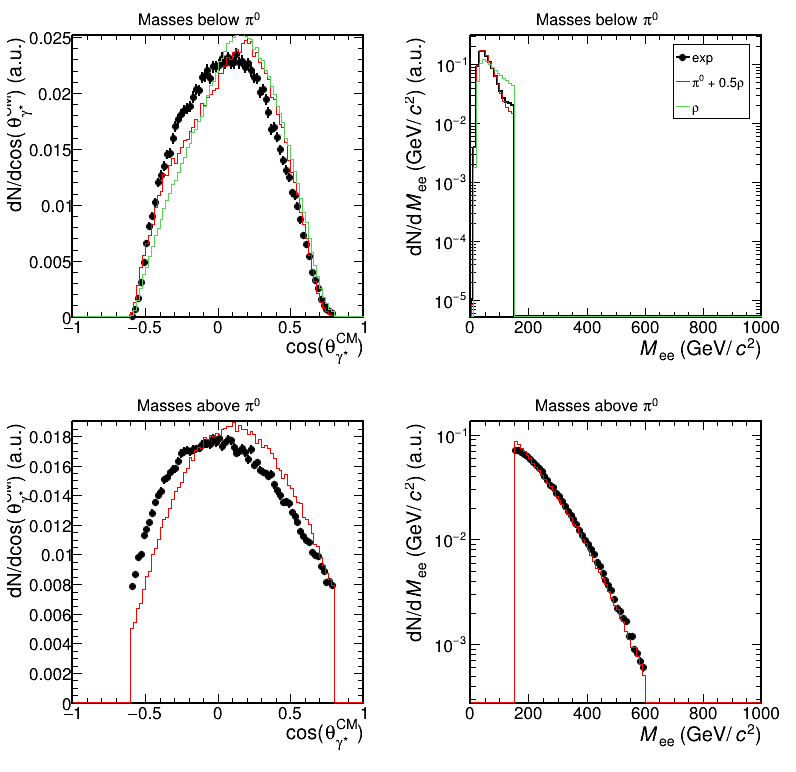

In [19]:
hmodelLowM_rho = histMakerMC_mix.make_hists(1.0) if event_mixing else histMakerMC_rho.make_hists(1.0)
hmodelLowM_rho[2][0].SetLineColor(8)
hmodelLowM_rho[1][0].SetLineColor(8)

hmodelLowM = histMakerMC_pi0.make_hists(1.0)

fraction = 0.5

hmodelLowM[2][0].Scale(1.0/hmodelLowM[2][0].Integral())
hmodelLowM[1][0].Scale(1.0/hmodelLowM[1][0].Integral())
hmodelLowM_rho[2][0].Scale(1.0/hmodelLowM_rho[2][0].Integral())
hmodelLowM_rho[1][0].Scale(1.0/hmodelLowM_rho[1][0].Integral())

hmodelLowM[2][0].Add(hmodelLowM_rho[2][0], fraction)
hmodelLowM[1][0].Add(hmodelLowM_rho[1][0], fraction)

hmodelLowM[2][0].SetLineColor(2)
hmodelLowM[1][0].SetLineColor(2)
hmodelHigM = get_hist_maker_mc(3).make_hists(1.0)
hmodelHigM[2][1].SetLineColor(2)
hmodelHigM[1][1].SetLineColor(2)

cc = TCanvas("cc","cc",800,800)
cc.Divide(2,2)
cc.Draw()

pad = cc.cd(1)
set_pad(pad)
dataScale = 1./histsData_np[2][0].Integral()
histsData_np[2][0].Scale(dataScale)
histsData_pp[2][0].Scale(dataScale)
histsData_nn[2][0].Scale(dataScale)
hmodelLowM[2][0].Scale(1./hmodelLowM[2][0].Integral())
hmodelLowM_rho[2][0].Scale(1./hmodelLowM_rho[2][0].Integral())
histsData_np[2][0].GetXaxis().SetTitle("cos(#theta^{CM}_{#gamma*})")
histsData_np[2][0].SetTitle("Masses below #pi^{0}")

set_th1(histsData_np[2][0], histsData_np[2][0].GetXaxis().GetTitle(), 
       f"dN/d{histsData_np[2][0].GetXaxis().GetTitle()} (a.u.)", 505, 20, 0.8, 1)
histsData_np[2][0].Draw()
#histsData_pp[2][0].Draw("SAME")
#histsData_nn[2][0].Draw("SAME")
hmodelLowM[2][0].Draw("SAMEHIST")
hmodelLowM_rho[2][0].Draw("SAMEHIST")

pad = cc.cd(2)
pad.SetLogy()
set_pad(pad)
histsData_np[1][0].Scale(1./histsData_np[1][0].Integral())
hmodelLowM[1][0].Scale(1./hmodelLowM[1][0].Integral())
hmodelLowM_rho[1][0].Scale(1./hmodelLowM_rho[1][0].Integral())
histsData_np[1][0].SetTitle("Masses below #pi^{0}")
histsData_np[1][0].GetXaxis().SetTitle("#it{M}_{ee} (GeV/#it{c}^{2})")

set_th1(histsData_np[1][0], histsData_np[1][0].GetXaxis().GetTitle(), 
       f"dN/d{histsData_np[1][0].GetXaxis().GetTitle()} (a.u.)", 505, 20, 0.8, 1)
histsData_np[1][0].Draw("HIST")
hmodelLowM[1][0].Draw("SAMEHIST")
hmodelLowM_rho[1][0].Draw("SAMEHIST")

legend = TLegend(0.7, 0.7, 0.9, 0.9)
legend.AddEntry(histsData_np[1][0], "exp", "pl")
legend.AddEntry(hmodelLowM[1][0], f"#pi^{{0}} + {fraction}#rho", "l")
legend.AddEntry(hmodelLowM_rho[1][0], "#rho", "l")
legend.Draw()

pad = cc.cd(3)
set_pad(pad)
histsData_np[2][1].Scale(1./histsData_np[2][1].Integral())
hmodelHigM[2][1].Scale(1./hmodelHigM[2][1].Integral())
hmodelLowM_rho[2][1].Scale(1./hmodelLowM_rho[2][1].Integral())
histsData_np[2][1].GetXaxis().SetTitle("cos(#theta^{CM}_{#gamma*})")
histsData_np[2][1].SetTitle("Masses above #pi^{0}")

set_th1(histsData_np[2][1], histsData_np[2][1].GetXaxis().GetTitle(), 
       f"dN/d{histsData_np[2][1].GetXaxis().GetTitle()} (a.u.)", 505, 20, 0.8, 1)
histsData_np[2][1].Draw()
hmodelHigM[2][1].Draw("SAMEHIST")
#hmodelLowM_rho[2][1].Draw("SAMEHIST")

pad = cc.cd(4)
pad.SetLogy()
set_pad(pad)
histsData_np[1][1].Scale(1./histsData_np[1][1].Integral())
hmodelHigM[1][1].Scale(1./hmodelHigM[1][1].Integral())
hmodelLowM_rho[1][1].Scale(1./hmodelLowM_rho[1][1].Integral())
histsData_np[1][1].GetXaxis().SetTitle("#it{M}_{ee} (GeV/#it{c}^{2})")
histsData_np[1][1].SetTitle("Masses above #pi^{0}")

set_th1(histsData_np[1][1], histsData_np[1][1].GetXaxis().GetTitle(), 
       f"dN/d{histsData_np[1][1].GetXaxis().GetTitle()} (a.u.)", 505, 20, 0.8, 1)
histsData_np[1][1].Draw()
hmodelHigM[1][1].Draw("SAMEHIST")
#hmodelLowM_rho[1][1].Draw("SAMEHIST")

cc.SaveAs(f"{DIR_NAME}/cmp_mass_z.gif")

Info in <TCanvas::Print>: gif file results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr/cacc.gif has been created


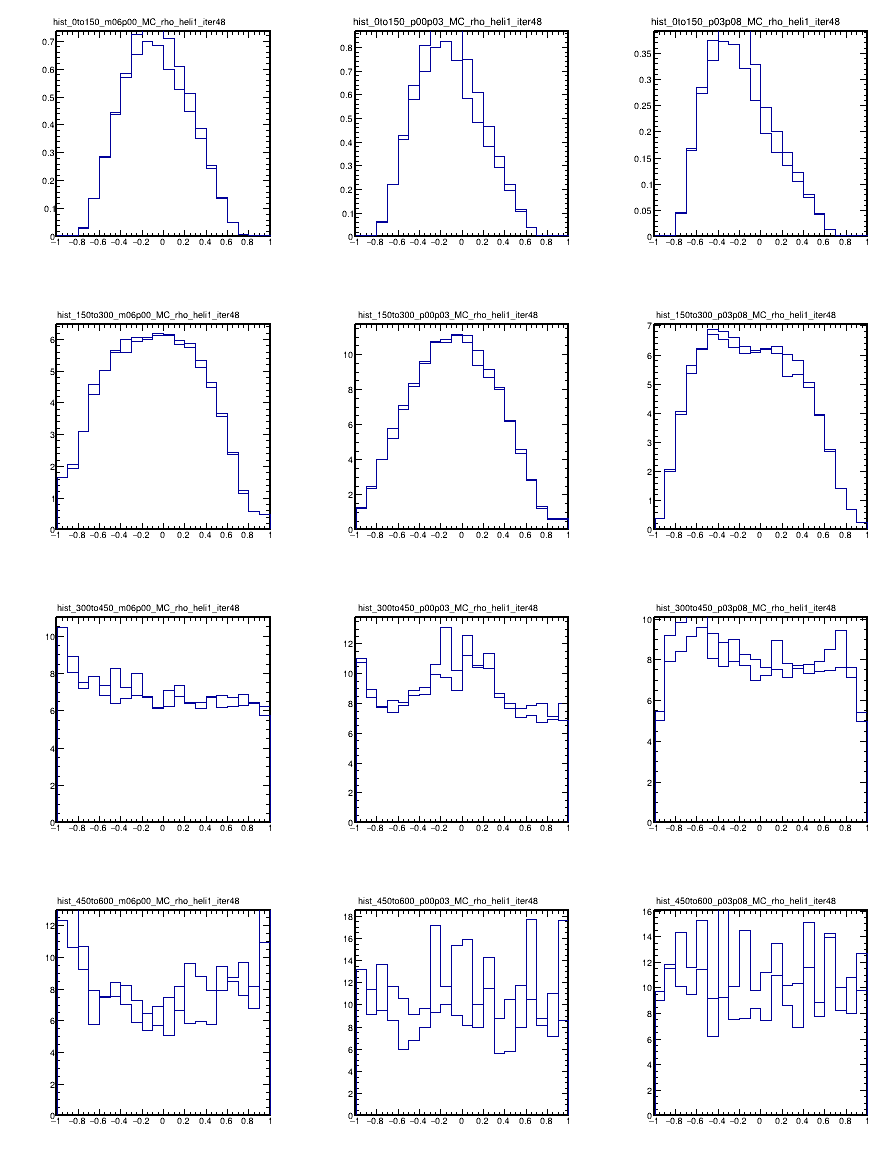

In [20]:
cacc.Draw()
cacc.SaveAs(f"{DIR_NAME}/cacc.gif")

Info in <TCanvas::Print>: gif file results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr/cacc.gif has been created
